### 3D convolution with CNN's in Keras

see https://www.kaggle.com/shivamb/3d-convolutions-understanding-use-case for pictures

In [1]:
import numpy as np
from sklearn.metrics import confusion_matrix, accuracy_score
from matplotlib.pyplot import cm
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import h5py
import keras
from keras.layers import Conv3D, MaxPool3D, Flatten, Dense
from keras.layers import Dropout, Input, BatchNormalization
from keras.losses import categorical_crossentropy
from keras.optimizers import Adadelta
from keras.models import Model
from keras import backend as K
from tensorflow.python.client import device_lib

import sys
sys.path.insert(0, '3d_mnist')
import plot3D, voxelgrid

Using TensorFlow backend.


In [2]:
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 13067493860411211615
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 2200962474001844055
physical_device_desc: "device: XLA_GPU device"
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 7363497607231633446
physical_device_desc: "device: XLA_CPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 10618617856
locality {
  bus_id: 1
  links {
  }
}
incarnation: 1807869444252349932
physical_device_desc: "device: 0, name: GeForce GTX 1080 Ti, pci bus id: 0000:65:00.0, compute capability: 6.1"
, name: "/device:GPU:1"
device_type: "GPU"
memory_limit: 7901999924
locality {
  bus_id: 1
  links {
  }
}
incarnation: 13384637689045674310
physical_device_desc: "device: 1, name: GeForce GTX 1080, pci bus id: 0000:17:00.0, compute capability: 6.1"
]


In [3]:
K.tensorflow_backend._get_available_gpus()

['/job:localhost/replica:0/task:0/device:GPU:0',
 '/job:localhost/replica:0/task:0/device:GPU:1']

download dataset from kaggle:
    
   https://www.kaggle.com/daavoo/3d-mnist/version/13 

In [4]:
%matplotlib inline

In [5]:
with h5py.File('../mnist_data/3d_mnist/full_dataset_vectors.h5', 'r') as dataset:
    x_train = dataset["X_train"][:]
    x_test = dataset["X_test"][:]
    y_train = dataset["y_train"][:]
    y_test = dataset["y_test"][:]

In [6]:
y_train[0], y_train.shape, y_test.shape, x_train.shape, x_test.shape,

(5, (10000,), (2000,), (10000, 4096), (2000, 4096))

In [7]:
with h5py.File("../mnist_data/3d_mnist/train_point_clouds.h5", "r") as points_dataset:        
    digits = []
    for i in range(10):
        digit = (points_dataset[str(i)]["img"][:], 
                 points_dataset[str(i)]["points"][:], 
                 points_dataset[str(i)].attrs["label"]) 
        digits.append(digit)

In [8]:
x_c = [r[0] for r in digits[0][1]]
y_c = [r[1] for r in digits[0][1]]
z_c = [r[2] for r in digits[0][1]]

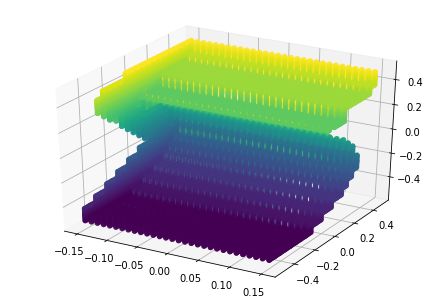

In [9]:
fig = plt.figure()
ax = Axes3D(fig)

ax.scatter(x_c, y_c, z_c, c=z_c)
plt.show()

In [10]:
xtrain = np.ndarray((x_train.shape[0], x_train.shape[1], 3))
xtest = np.ndarray((x_test.shape[0], x_test.shape[1], 3))

In [11]:
def add_rgb_dimention(array):
    scaler_map = cm.ScalarMappable(cmap="Oranges")
    array = scaler_map.to_rgba(array)[:, : -1]
    return array

for i in range(x_train.shape[0]):
    xtrain[i] = add_rgb_dimention(x_train[i])
for i in range(x_test.shape[0]):
    xtest[i] = add_rgb_dimention(x_test[i])

In [12]:
x_train.shape

(10000, 4096)

reshape data for 3D convolution

rows = x_train.shape[0]

x,y,z = 3D size

channels = 3

In [13]:
xtrain = xtrain.reshape(x_train.shape[0], 16, 16, 16, 3)
xtest = xtest.reshape(x_test.shape[0], 16, 16, 16, 3)

In [14]:
xtrain.shape, 4096/16/16

((10000, 16, 16, 16, 3), 16.0)

In [15]:
y_train[0], y_train.shape

(5, (10000,))

one hot encode

In [16]:
y_train = keras.utils.to_categorical(y_train, 10)
y_test = keras.utils.to_categorical(y_test, 10)

In [17]:
y_train[0], y_train.shape

(array([0., 0., 0., 0., 0., 1., 0., 0., 0., 0.], dtype=float32), (10000, 10))

### Model

In [18]:
## input layer
input_layer = Input((16, 16, 16, 3))

## convolutional layers
conv_layer1 = Conv3D(filters=8, kernel_size=(3, 3, 3), activation='relu')(input_layer)
conv_layer2 = Conv3D(filters=16, kernel_size=(3, 3, 3), activation='relu')(conv_layer1)

## add max pooling to obtain the most imformatic features
pooling_layer1 = MaxPool3D(pool_size=(2, 2, 2))(conv_layer2)

conv_layer3 = Conv3D(filters=32, kernel_size=(3, 3, 3), activation='relu')(pooling_layer1)
conv_layer4 = Conv3D(filters=64, kernel_size=(3, 3, 3), activation='relu')(conv_layer3)
pooling_layer2 = MaxPool3D(pool_size=(2, 2, 2))(conv_layer4)

## perform batch normalization on the convolution outputs before feeding it to MLP architecture
pooling_layer2 = BatchNormalization()(pooling_layer2)
flatten_layer = Flatten()(pooling_layer2)

## create an MLP architecture with dense layers : 4096 -> 512 -> 10
## add dropouts to avoid overfitting / perform regularization
dense_layer1 = Dense(units=2048, activation='relu')(flatten_layer)
dense_layer1 = Dropout(0.4)(dense_layer1)
dense_layer2 = Dense(units=512, activation='relu')(dense_layer1)
dense_layer2 = Dropout(0.4)(dense_layer2)
output_layer = Dense(units=10, activation='softmax')(dense_layer2)

## define the model with input layer and output layer
model = Model(inputs=input_layer, outputs=output_layer)


In [19]:
model.compile(loss=categorical_crossentropy, optimizer=Adadelta(lr=0.1), metrics=['acc'])
model.fit(x=xtrain, y=y_train, batch_size=128, epochs=50, validation_split=0.2)

Train on 8000 samples, validate on 2000 samples
Epoch 1/50


UnknownError: Failed to get convolution algorithm. This is probably because cuDNN failed to initialize, so try looking to see if a warning log message was printed above.
	 [[{{node conv3d_1/convolution}} = Conv3D[T=DT_FLOAT, _class=["loc:@train...opFilterV2"], data_format="NDHWC", dilations=[1, 1, 1, 1, 1], padding="VALID", strides=[1, 1, 1, 1, 1], _device="/job:localhost/replica:0/task:0/device:GPU:0"](_arg_input_1_0_0/_121, conv3d_1/kernel/read)]]
	 [[{{node metrics/acc/Mean/_169}} = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/device:CPU:0", send_device="/job:localhost/replica:0/task:0/device:GPU:0", send_device_incarnation=1, tensor_name="edge_1659_metrics/acc/Mean", tensor_type=DT_FLOAT, _device="/job:localhost/replica:0/task:0/device:CPU:0"]()]]